In [ ]:
%%capture
%pip install python-dotenv neo4j_tools

In [ ]:

# Neo4j Connection Setup
from neo4j import GraphDatabase

from dotenv import load_dotenv
import os
load_dotenv('ws.env', override=True)

# Replace these with your Neo4j credentials and connection URI
# Neo4j
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')

# Create a Neo4j driver instance
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Your Cypher query

print("Checking the connection:")

# Helper function to run and display Cypher query results
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        # Collect results as a list
        records = [record.data() for record in result]
        # Print the records
        for record in records:
            print(record)
        return records

# Run the query; check the connection
query = "MATCH p=()-[]-() limit 1 RETURN p"
results = run_query(query)

## Understanding the Pharma Supply Chain Model

This **graph model** maps the *full lifecycle* of a pharmaceutical product, connecting key entities such as:

- **Suppliers**
- **Raw Materials (RM)**
- **Active Pharmaceutical Ingredients (APIs)**
- Product stages: **BULK → DP → Finished Drug Product**
- **Batches**, **Equipment**, and **Distributors**

It models key relationships like:
- `SUPPLIES_RM` – how suppliers provide raw materials  
- `PRODUCT_FLOW` – how materials and products move through the manufacturing chain  
- `DISTRIBUTED_BY` – how finished goods reach distributors

These connections enable powerful analysis of:
- *Upstream and downstream dependencies*
- *Potential bottlenecks*
- *End-to-end supply chain visibility*

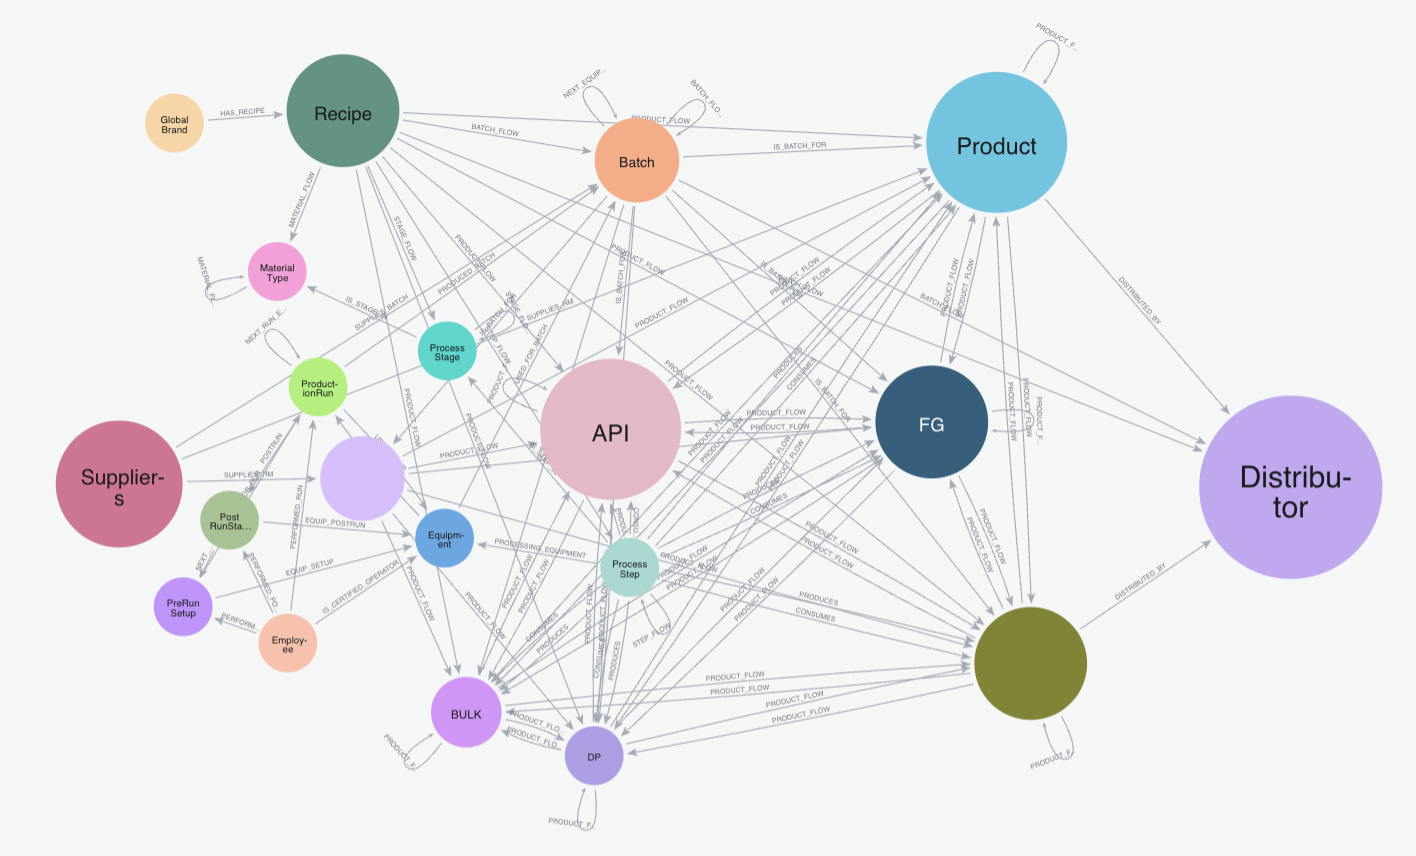
<br>
Explore how this graph model helps answer real business questions?   ➡️ 

In [ ]:
query = "call db.schema.visualization()"
results = run_query(query)

## Find the Dependency Chain
**Suppliers->Raw Materials->API->Drug Products->Finished Product->Distributors**

This query traces the **dependency chain** for a specific product, showing how it flows from **Suppliers** through **Raw Materials** to the final **Product**, and then to **Distributors**.  It helps identify critical **upstream and downstream dependencies** in the supply chain for a given `productSKU`

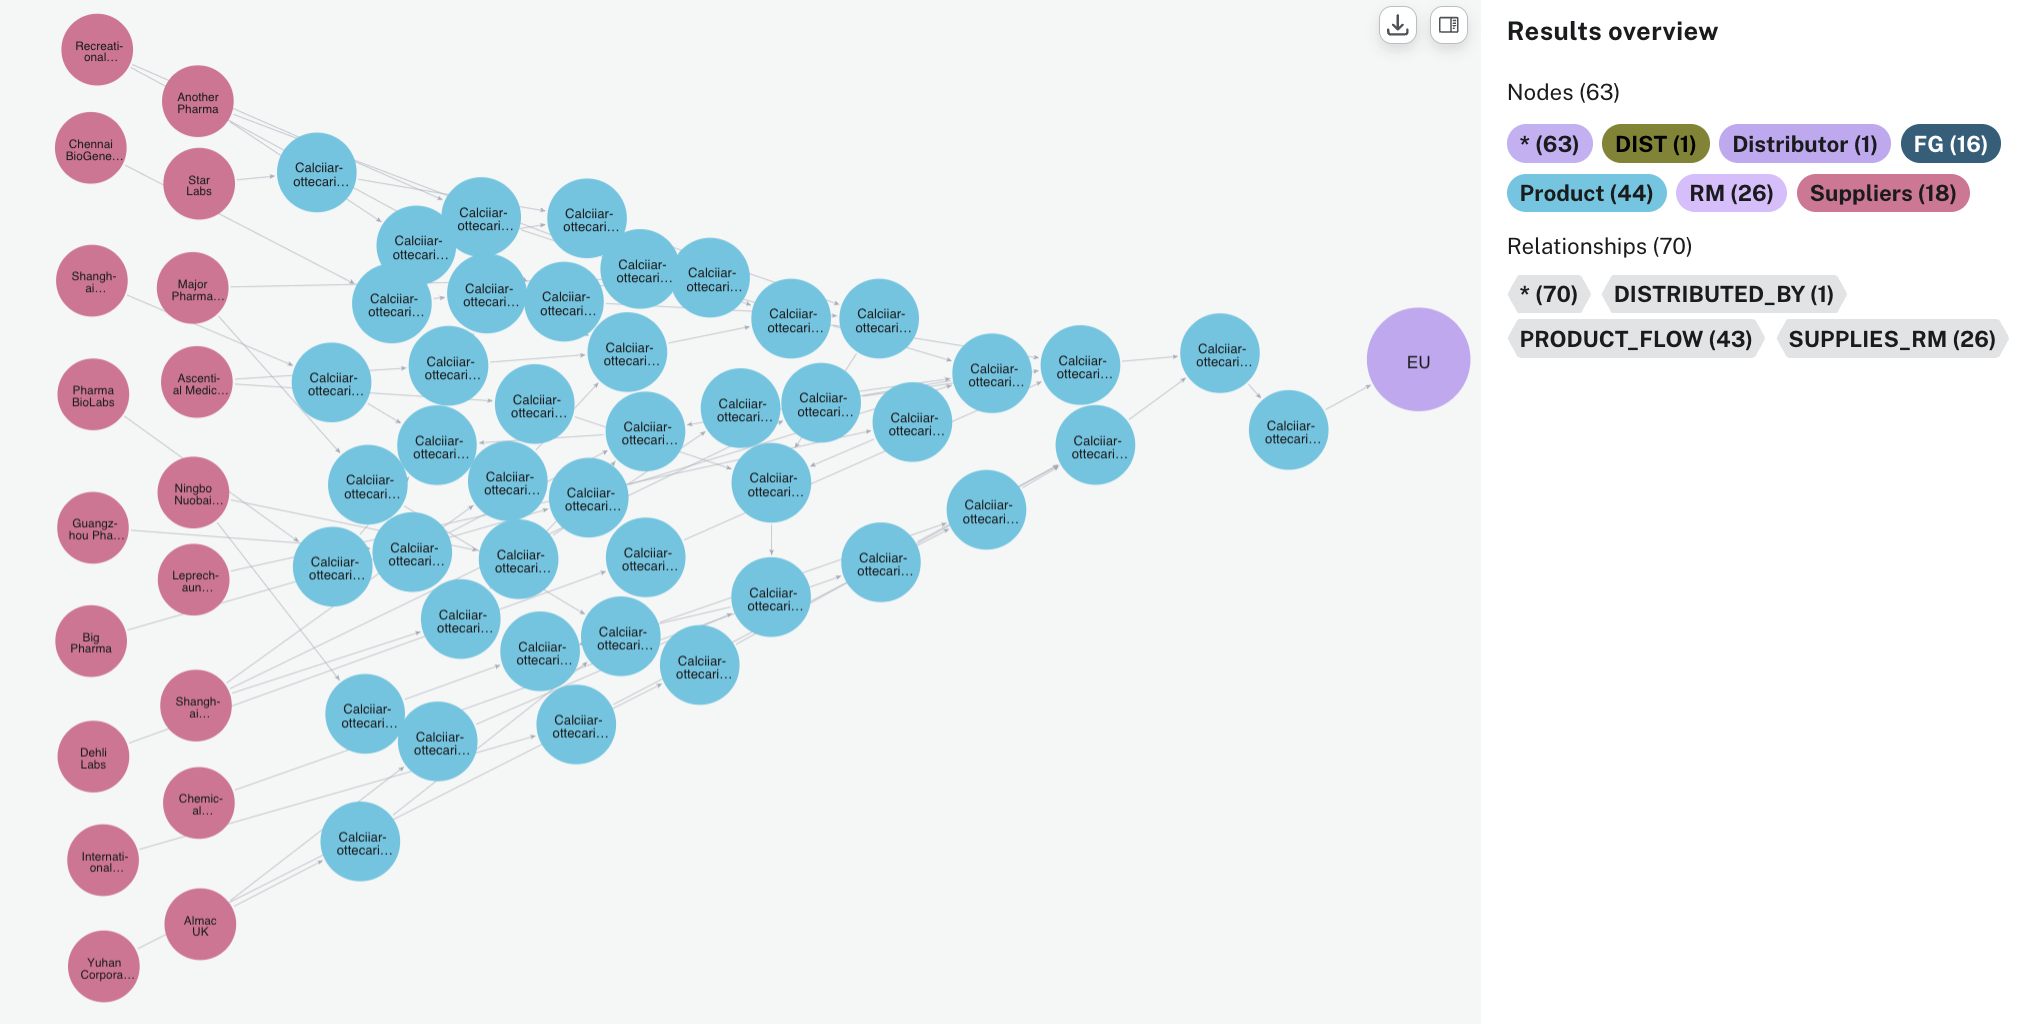

In [ ]:
query = """
MATCH path = (sup:Suppliers)-[:SUPPLIES_RM]->(rm:RM)-[:PRODUCT_FLOW*]->(prod:Product)-[:DISTRIBUTED_BY]->(dist:Distributor)
WHERE prod.productSKU = '7e882292-ae98-45eb-8119-596b5d8b73e1'
RETURN nodes(path) AS nodes, relationships(path) AS relationships
"""

results = run_query(query)

## Identify Raw Materials with limited Suppliers

This query finds *raw materials (RMs)* that are supplied by *only one supplier*, indicating a potential *supply chain bottleneck* or *dependency risk*.  It counts how many suppliers exist for each RM and filters for those with only one (`supplierCount = 1`).  
The result includes the *raw material's SKU*, *brand name*, and the number of suppliers, helping stakeholders identify and mitigate *single points of failure* in sourcing.

*(Showcase Dependency Pattern)*

In [ ]:
query = """
MATCH (rm:RM)<-[:SUPPLIES_RM]-(sup:Suppliers)
WITH rm, COUNT(sup) AS supplierCount
WHERE supplierCount = 1
RETURN rm.productSKU AS rawMaterialSKU, 
       rm.globalBrand AS rawMaterialName, 
       supplierCount
ORDER BY supplierCount
"""

run_query(query)

## Identify APIs Used in Multiple Drug Products with Potential Supply Risk

This query identifies *Active Pharmaceutical Ingredients (APIs)* that are used across several *Drug Products*.  
APIs with broader usage may present a **supply risk** if disruptions occur, especially when demand spans multiple products.  
To focus on more impactful cases, the query filters for APIs associated with more than **4** products.

> 🔎 *Highlights a Dependency Pattern within the Drug Product<->API relationships.*

In [ ]:
query = """
MATCH (api:API)-[:PRODUCT_FLOW]->(dp:DP)
WITH api, COUNT(dp) AS productCount
WHERE productCount > 4
RETURN api.productSKU AS apiSKU, 
       api.globalBrand AS apiName, 
       productCount
ORDER BY productCount DESC
"""
run_query(query)

## Identify Single-Supplier APIs with Broad Product Impact

This query highlights **critical supply chain vulnerabilities** by identifying *Active Pharmaceutical Ingredients (APIs)* that meet **two key risk criteria**:

1. They are used in **multiple Drug Products**, indicating *high reliance* across the product portfolio.
2. They are supplied by **only one supplier**, creating a potential *single point of failure*.

By combining these conditions, the query surfaces **APIs that pose a high dependency risk** — helping you proactively identify bottlenecks and mitigate disruption.

> 🔎 *Showcases a Dependency Pattern in the supply chain graph.*

In [ ]:
query = """
MATCH (sup:Suppliers)-[:SUPPLIES_RM]->(rm:RM)-[:PRODUCT_FLOW]->(api:API)-[:PRODUCT_FLOW]->(dp:DP)
WITH api, COUNT(dp) AS productCount, COLLECT(DISTINCT dp) AS dpList, COUNT(DISTINCT sup) AS supplierCount, COLLECT(DISTINCT sup.companyName) AS supplierList
WHERE productCount > 4
RETURN api.productSKU AS apiSKU, 
       api.globalBrand AS apiName, 
       productCount, 
       supplierCount, 
       supplierList,
       CASE 
           WHEN supplierCount = 1 THEN '⚠️ Single Supplier Bottleneck!!'
           ELSE 'Multiple Suppliers Available'
       END AS SupplierRisk
ORDER BY supplierCount ASC
"""

run_query(query)


## How Does Distributor Demand Flow Back to Raw Material Requirements?

This query answers a key supply chain question:  
**“What quantity of raw materials is needed to fulfill demand at the distributor level?”**

It works by tracing demand *backward* through the supply chain — from the distributor, all the way to the raw material and its supplier.

**Step-by-Step Breakdown:**

1. Start with a *specific product* being requested by a distributor (identified by *`productSKU`*).
2. Capture the **demand quantity** coming from that distributor.
3. Find the **raw materials (RMs)** involved in making that product, based on product attributes like *brand*, *strength*, *form*, and *generation*.
4. Trace the **shortest path** from the raw material back to the product  
   (*via intermediate stages like API, BULK, DP, etc.*).
5. Identify **suppliers** for each raw material.
6. Calculate how much raw material is needed by factoring in all intermediate production steps  
   (*using `conversionRatio` values if available*).

> 🧩 *Uses a ShortestPath Pattern to model back-pressure through the supply chain.*

In [ ]:
query = """
MATCH (d:Distributor)<-[db:DISTRIBUTED_BY]-(prod:Product)
WHERE prod.productSKU = '9a6b431f-3a38-4b45-9451-fbf39b2e2fd0'

MATCH (api)<-[pf2:PRODUCT_FLOW]-(rm:RM)
WHERE pf2.globalBrand = prod.globalBrand
  AND pf2.strength = prod.strength
  AND pf2.form = prod.form
  AND pf2.generation = prod.generation

WITH d, db.demandQty AS demandQty, db, prod, COLLECT(DISTINCT rm) AS RMList
UNWIND RMList AS curRM

MATCH p = shortestPath((prod)<-[pf1:PRODUCT_FLOW*]-(curRM))
MATCH p3 = (myProd:Product)<-[pf:PRODUCT_FLOW]-(curRM)<-[:SUPPLIES_RM]-(sup:Suppliers)
WHERE pf.globalBrand = prod.globalBrand
  AND pf.strength = prod.strength
  AND pf.form = prod.form
  AND pf.generation = prod.generation
  AND pf.market = d.market

RETURN sup.companyName AS supplierName,
       curRM.productSKU AS rawMaterialSKU,
       apoc.coll.disjunction(["Product"], labels(myProd))[0] AS usedBy,
       demandQty,
       REDUCE(rmQty = demandQty, rel IN relationships(p) |
         TOINTEGER(ROUND(rmQty / (COALESCE(rel.conversionRatio, 1.0)), 0))
       ) AS rawMaterialQty
ORDER BY usedBy, supplierName, rawMaterialSKU
"""
run_query(query)

## Identify Downstream Impact from a Critical API *(Blast Radius)*

This query identifies the **blast radius** of a critical API by tracing all downstream nodes that rely on it through the `PRODUCT_FLOW` relationship.

By starting from a specific `API` (identified by `productSKU`), it follows connected product paths outward — up to **`10`** levels deep — to uncover potential **impact zones** such as:

- Drug Products (DP, FG)
- Finished Goods
- Batches
- Distributors

This helps assess how failure or disruption at the API level could propagate through the supply chain, revealing **high-risk dependencies** and enabling **proactive mitigation planning**.

> ⚠️ *Useful for simulating risk, disruption impact, or failure analysis.*

In [ ]:
query = """
MATCH (api:API {productSKU: '93337184-9e63-4ff5-9cf9-3e6063e21700'})
CALL apoc.path.subgraphNodes(api, {
  relationshipFilter: 'PRODUCT_FLOW>',
  labelFilter: '-Supplier',
  maxLevel: 10
})
YIELD node
RETURN DISTINCT node
"""
run_query(query)

## Downstream Impact from a Single Supplier *(Blast Radius)*

This query identifies the blast radius of a specific supplier — by tracing all downstream nodes that depend on the raw materials they supply.

It follows the SUPPLIES_RM and PRODUCT_FLOW relationships to uncover which products, APIs, intermediates, or finished goods could be affected if this supplier is disrupted.

This analysis is critical for:
	•	Identifying single points of failure
	•	Understanding how risk propagates through the supply chain
	•	Informing resilience planning and supplier diversification

> ⚠️ Highlights a Supplier-Centric Dependency Pattern

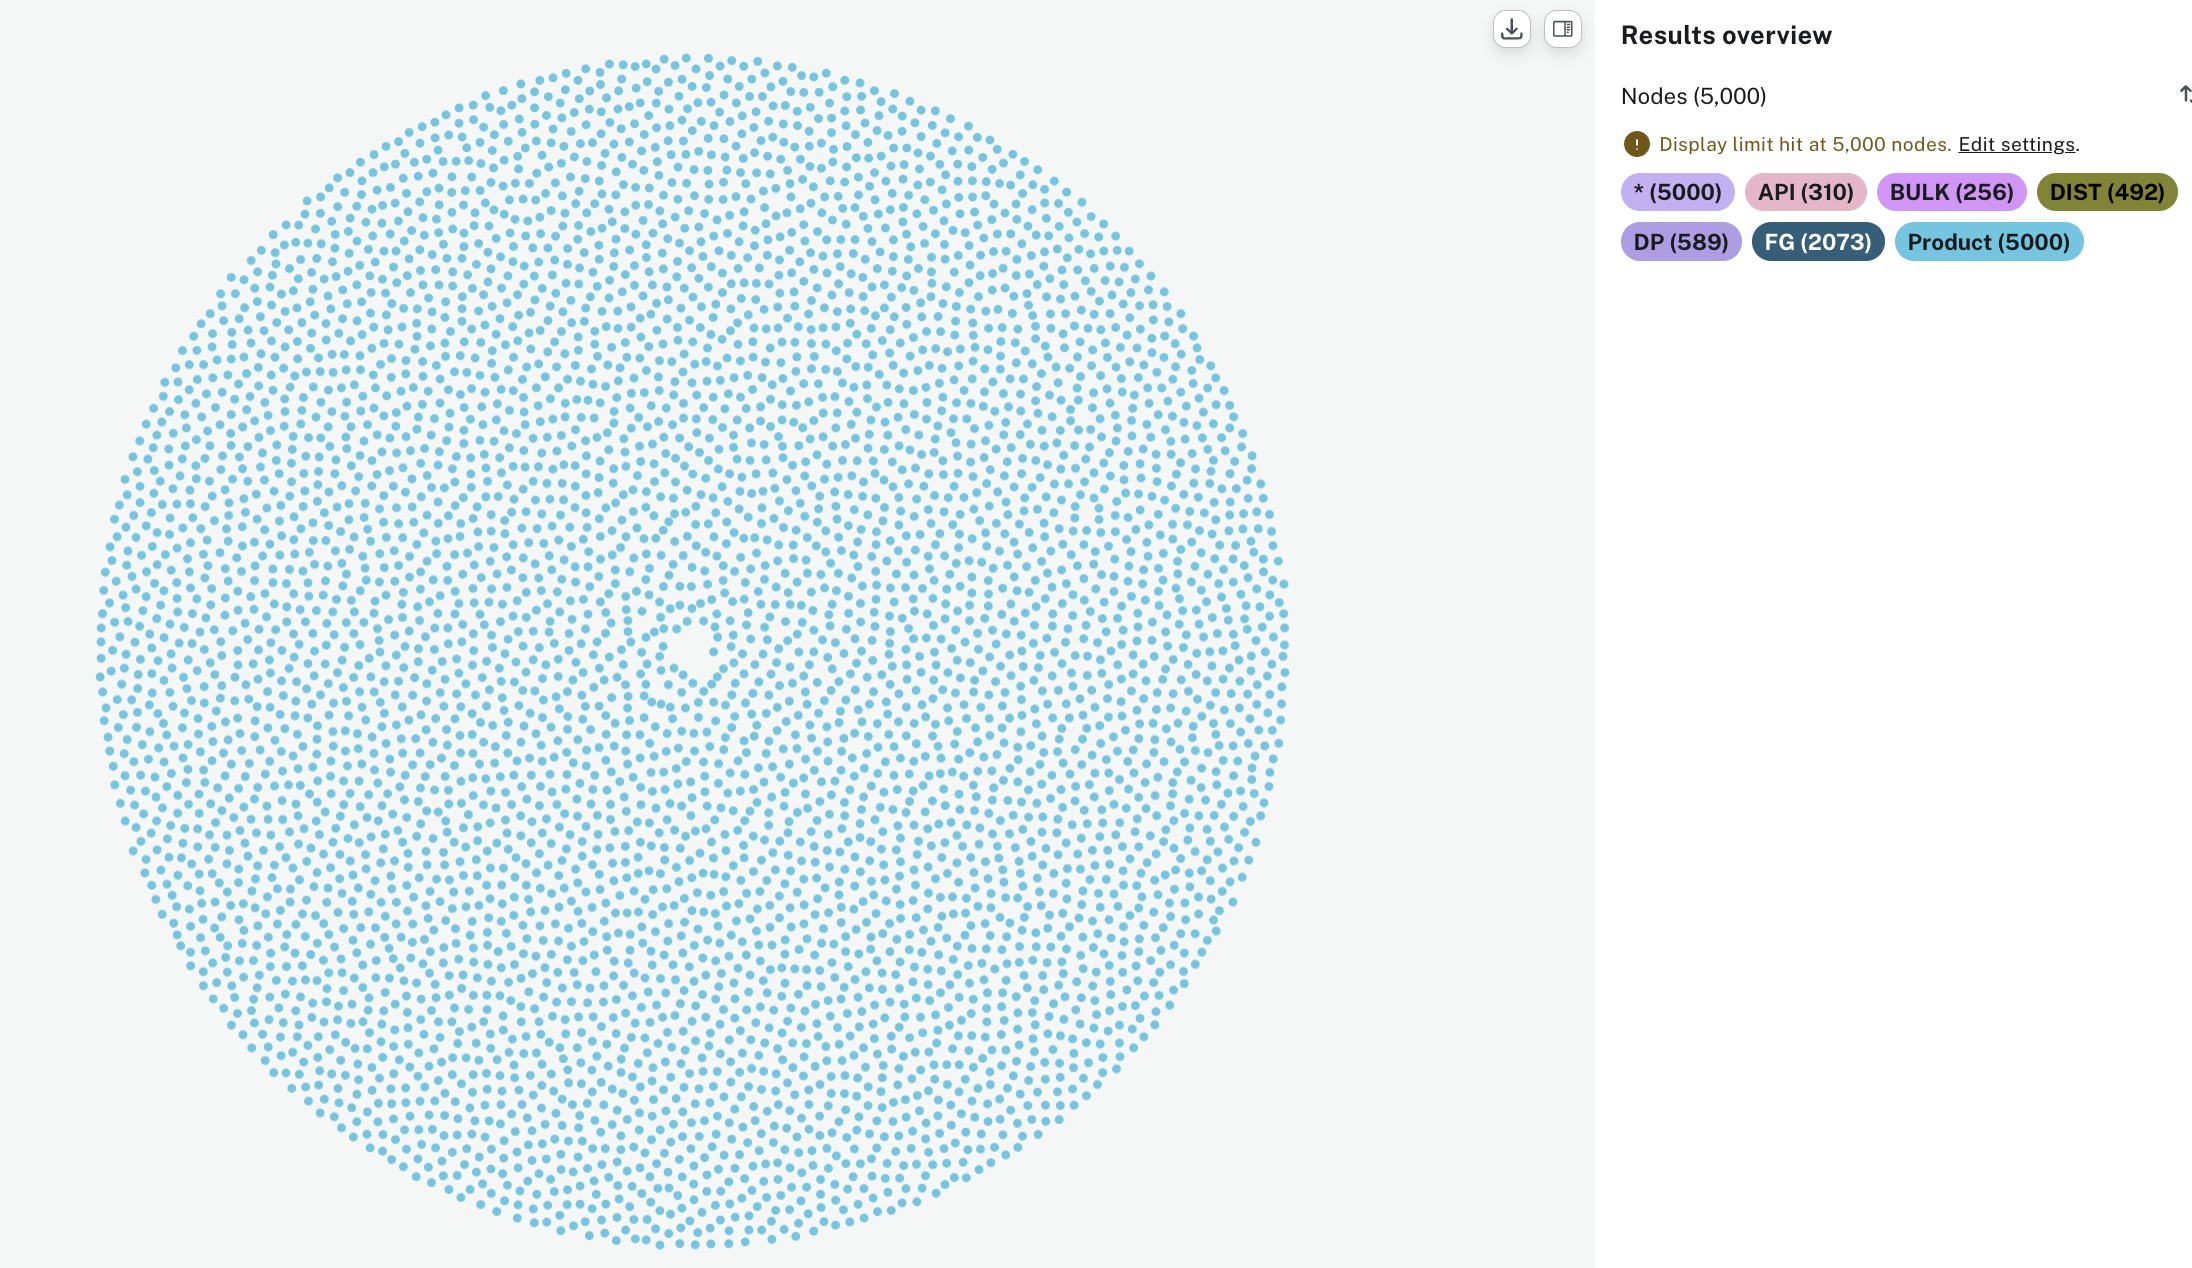

In [ ]:
query = """
MATCH (sup:Suppliers {companyName: 'Guangzhou Pharm & BioLabs'})
MATCH path = (sup)-[:SUPPLIES_RM]->(:RM)-[:PRODUCT_FLOW*]->(affected)
RETURN DISTINCT affected limit 200
"""
run_query(query)